In [1]:
%matplotlib inline
from pprint import pprint
from collections import defaultdict

import numpy as np
import math
import matplotlib.pyplot as plt
import warnings

import sklearn.linear_model

from sklearn.grid_search import GridSearchCV
from sklearn import metrics

from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve

import sys
sys.path.append('../dev')
from ml_plot import plot_validation_curve
from ml_plot import PredictCV, my_plot_learning_curve
from ml_plot import plot_prediction_curve
from ml_plot import get_dataset, eval_predictions

# Configuration

In [2]:
# PROJECT = 'nova'
# PROJECT = 'swift'
# PROJECT = 'cinder'
PROJECT = 'heat'
# PROJECT = 'glance'

# IMPORTANCE = 'crit'
# IMPORTANCE = 'high+'
IMPORTANCE = 'med+'
# IMPORTANCE = 'low+'

# SIZE = 100
#SIZE = 250
# SIZE = 0.1
SIZE = 0.5

SCORING = 'f1'         # (precision * recall) / (precision + recall)
# SCORING = 'accuracy'   # (TP + TN) / all values
# SCORING = 'precision'  # TP / (TP + FP)
# SCORING = 'recall'     # TP / (TP + FN)
# SCORING = 'average_precision'
# SCORING = 'roc_auc'

JOBS = 1
VERBOSE = 0

warnings.filterwarnings("ignore", 'F-score is ill-defined')

# Load Data

In [3]:
#%%capture
Y, X = get_dataset(PROJECT, IMPORTANCE)

loading bug data
  total LP bugs: 1388
  Entries annotated: 536
loading Git commit data
  total git_commits: 7566
  bug fix commits: 1353
  commits with change_id: 4084
  bug fix with change_id: 1353
loading change data
  total gerrit changes with detail: 4126
  all_change_details: 4126
  total gerrit changes: 4132
  all_changes: 4132
combined_commits: 7566
Determining legacy cut-off
  Setting cutoff to: 12/11/2012
  Mainline Commits ignored due to legacy: 995  out of: 4507
  Total commite requiring blame computation: 1113

Computing Blame
Loaded blame
  Initial Blame cache size: 826
  bug fix commits: 1113
. . . . . . . . . . 100 . . . . . . . . . . 200 . . . . . . . . . . 300 . . . . . . . . . . 400 . . . . . . . . . . 500 . . . . . . . . . . 600 . . . . . . . . . . 700 . . . . . . . . . . 800 . . . . . . . . . . 900 . . . . . . . . . . 1000 . . . . . . . . . . 1100 .
  Saving updated Blame Cache


** Warning: Blame entries with missing guilt data: 17
Annotating Guilt
entries with no

### Select Split Strategy

In [4]:
history_size = 500
future_size = 300
#future_size = 500

In [5]:
cv = PredictCV(len(Y), history=history_size, future=future_size, n_iter=100)

# Initial Parameter Settings

In [6]:
estimator = sklearn.linear_model.SGDClassifier(class_weight='auto', alpha=0.005,
       learning_rate='optimal', loss='log', n_iter=400, n_jobs=1,
       shuffle=True, verbose=0)

In [7]:
n_iter = np.ceil(10**6 / history_size)  # see rule of thumb in section 1.3.5 of http://scikit-learn.org/stable/modules/sgd.html

In [8]:
alpha_range = 10.0 ** np.arange(-7, -1)
param_grid = dict(alpha=alpha_range, class_weight=['auto'], 
                  loss=['hinge', 'log', 'modified_huber', 'perceptron'], #'squared_hinge']
                  #eta0=[0.5, 0.1, 0.05, 0.01],
                  #learning_rate=['optimal', 'invscaling', 'constant'],
                  n_iter=[400], shuffle=[True])

grid = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=SCORING,
                    n_jobs=JOBS, pre_dispatch=2*JOBS,
                    verbose=VERBOSE)

grid.fit(X, Y)
print 'best_score: ', grid.best_score_
clf = grid.best_estimator_
grid.best_estimator_

best_score:  0.404787098978


SGDClassifier(alpha=0.01, class_weight='auto', epsilon=0.1, eta0=0.0,
       fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
       loss='hinge', n_iter=400, n_jobs=1, penalty='l2', power_t=0.5,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

# Validation Curves Example

### Impact of Gamma

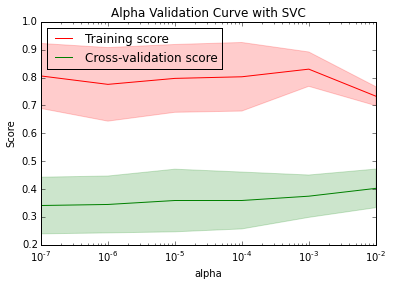

In [9]:
best_score, param_val, param_name = \
    plot_validation_curve(clf, X, Y, "alpha", alpha_range,
                      "Alpha Validation Curve with SVC",
                      cv=cv, scoring=SCORING, n_jobs=JOBS)

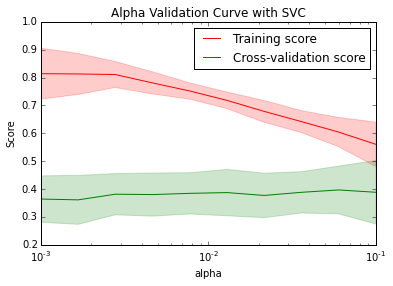

SGDClassifier(alpha=0.059948425031894091, class_weight='auto', epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=400, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [10]:
param_log10 = math.log10(param_val)
best_score, param_val, param_name = \
    plot_validation_curve(clf, X, Y, param_name, np.logspace(param_log10 - 1, param_log10 + 1, 10),
                      "Alpha Validation Curve with SVC",
                      cv=cv, scoring=SCORING, n_jobs=JOBS)
clf.set_params(**dict([[param_name, param_val]]))
clf

# Learning Curve

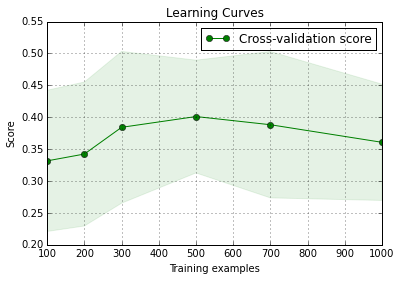

In [11]:
title = "Learning Curves"
my_plot_learning_curve(clf, title, X, Y,
                           n_jobs=JOBS, future=100,
                           history_sizes=[100, 200, 300, 500, 700, 1000], n_iter=100)
plt.show()

# Prediction Curve

<module 'matplotlib.pyplot' from '/Users/doug/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

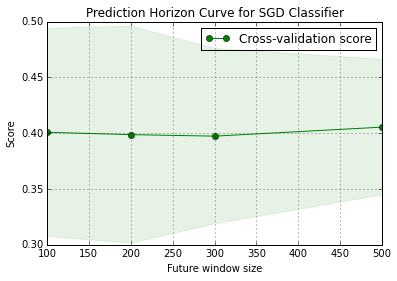

In [12]:
title = "Prediction Horizon Curve for SGD Classifier"
plot_prediction_curve(clf, title, X, Y,
                           n_jobs=JOBS, history=500,
                           future_sizes=[100, 200, 300, 500], n_iter=100)

In [13]:
SGD_results = eval_predictions(clf, X, Y, history_sizes=[500, 1000], future_sizes=[100, 500], n_iter=100)

** Predictions for hist=500 future=100 **

F1:        0.42  +/- 0.09
Accuracy:  0.65  +/- 0.07
Precision: 0.43  +/- 0.18
Recall:    0.48  +/- 0.14

Aggregate Confusion Matrix - 100 iterations
[[5112 1984]
 [1526 1378]]


** Predictions for hist=500 future=500 **

F1:        0.40  +/- 0.07
Accuracy:  0.64  +/- 0.04
Precision: 0.39  +/- 0.12
Recall:    0.50  +/- 0.17

Aggregate Confusion Matrix - 100 iterations
[[25452 11205]
 [ 7044  6299]]


** Predictions for hist=1000 future=100 **

F1:        0.39  +/- 0.10
Accuracy:  0.65  +/- 0.07
Precision: 0.33  +/- 0.10
Recall:    0.57  +/- 0.21

Aggregate Confusion Matrix - 100 iterations
[[5288 2463]
 [1026 1223]]


** Predictions for hist=1000 future=500 **

F1:        0.39  +/- 0.05
Accuracy:  0.64  +/- 0.04
Precision: 0.33  +/- 0.06
Recall:    0.54  +/- 0.15

Aggregate Confusion Matrix - 100 iterations
[[26314 12392]
 [ 5421  5873]]


